In [ ]:
%pip install scipy
%pip install matplotlib 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jn  # Bessel function of the first kind
from scipy.integrate import quad


In [ ]:

# Constants
wavelength = 0.0032  # meters
D = 0.520  # diameter of the aperture in meters
a = D / 2  # radius of the aperture
k = 2 * np.pi / wavelength  # wave number
z = 1.0  # distance from aperture (in meters)

# User-defined grid sizes
num_points_obs = 10  # Number of points in the observation plane
num_points_aperture = 10  # Number of points for the aperture grid
grid_size = 289  # Size of the grid in mm

# Define the grid for observation points (x, y) in the observation plane
x_obs = np.linspace(-grid_size, grid_size, num_points_obs)  # x range in mm
y_obs = np.linspace(-grid_size, grid_size, num_points_obs)  # y range in mm
X_obs, Y_obs = np.meshgrid(x_obs, y_obs)

# Define the grid for points on the aperture (x', y')
x_prime = np.linspace(-a, a, num_points_aperture)
y_prime = np.linspace(-a, a, num_points_aperture)
X_prime, Y_prime = np.meshgrid(x_prime, y_prime)

# Define the circular aperture mask (1 inside the aperture, 0 outside)
aperture_mask = np.sqrt(X_prime**2 + Y_prime**2) <= a

# Create a 2D grid for the observation points
R_obs = np.sqrt(X_obs**2 + Y_obs**2 + z**2)

# Vectorized version of the integral
r_prime = np.sqrt(
	(X_obs[:, :, None, None] - X_prime[None, None, :, :])**2 +
	(Y_obs[:, :, None, None] - Y_prime[None, None, :, :])**2 +
	z**2
)

# Only sum over points inside the aperture
aperture_mask_expanded = aperture_mask[None, None, :, :]
U = np.sum(np.exp(1j * k * r_prime) / r_prime * aperture_mask_expanded, axis=(2, 3))

# Normalize the field
U /= (1j * wavelength)

# Calculate the intensity (magnitude squared of the wavefield)
intensity = np.abs(U)**2

# Plot the intensity of the diffraction pattern
plt.figure(figsize=(8, 6))
plt.imshow(intensity, extent=[x_obs[0], x_obs[-1], y_obs[0], y_obs[-1]], cmap='hot', origin='lower')
plt.colorbar(label='Intensity')
plt.title('Diffraction Pattern from a Circular Aperture (Optimized)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


In [ ]:
# # Far field approximation -- much faster

# import numpy as np
# import matplotlib.pyplot as plt

# # Constants
# wavelength = 0.0032  # Wavelength of light (in meters, e.g., 650 nm)
# k = 2 * np.pi / wavelength  # Wave number
# R = 0.520  # Radius of the circular aperture (in meters)
# z = 250  # Observation distance (in meters)
# num_points = 512  # Grid size (power of 2 for efficient FFT)

# # Define the size of the grid (in meters)
# grid_size = 20  # Size of the observation grid (in degrees)
# dx = grid_size / num_points  # Grid spacing in x and y

# # Generate grid for observation points (2D plane)
# x_obs = np.linspace(-grid_size / 2, grid_size / 2, num_points)
# y_obs = np.linspace(-grid_size / 2, grid_size / 2, num_points)
# X_obs, Y_obs = np.meshgrid(x_obs, y_obs)

# # Create the binary circular aperture function (1 inside the circle, 0 outside)
# X_aperture = np.linspace(-R, R, num_points)
# Y_aperture = np.linspace(-R, R, num_points)
# X_aperture, Y_aperture = np.meshgrid(X_aperture, Y_aperture)
# aperture = (X_aperture**2 + Y_aperture**2 <= R**2).astype(float)

# # Compute the Fourier transform of the aperture (Far-field diffraction pattern)
# # Apply FFT and shift to center the zero frequency component
# aperture_ft = np.fft.fftshift(np.fft.fft2(aperture))

# # Calculate the spatial frequencies corresponding to the observation grid
# fx = np.fft.fftshift(np.fft.fftfreq(num_points, dx))
# fy = np.fft.fftshift(np.fft.fftfreq(num_points, dx))
# FX, FY = np.meshgrid(fx, fy)

# # Calculate the radial frequency (in terms of wave number)
# radius_freq = np.sqrt(FX**2 + FY**2)

# # Use the diffraction condition: scaling by (wavelength * z)
# # The scaling factor comes from the Fraunhofer approximation
# scaling_factor = np.exp(1j * k * z) * (wavelength * z) / (k)

# # Compute the diffraction pattern using the scaled Fourier transform
# U_obs = np.abs(scaling_factor * aperture_ft)**2

# # Normalize and display the diffraction pattern
# U_obs /= np.max(U_obs)  # Normalize to max value for visualization

# # Plot the diffraction pattern (intensity)
# plt.figure(figsize=(8, 6))
# plt.imshow(np.log(U_obs), extent=[x_obs.min(), x_obs.max(), y_obs.min(), y_obs.max()],cmap='viridis', vmin=-20, vmax=0)
# plt.colorbar(label='Intensity')
# plt.title('Diffraction Pattern from a Circular Aperture (FFT-based)')
# plt.xlabel('x (Degrees)')
# plt.ylabel('y (Degrees)')
# plt.xlim(-2, 2)  # Set x-axis limits
# plt.ylim(-2, 2)
# plt.show()


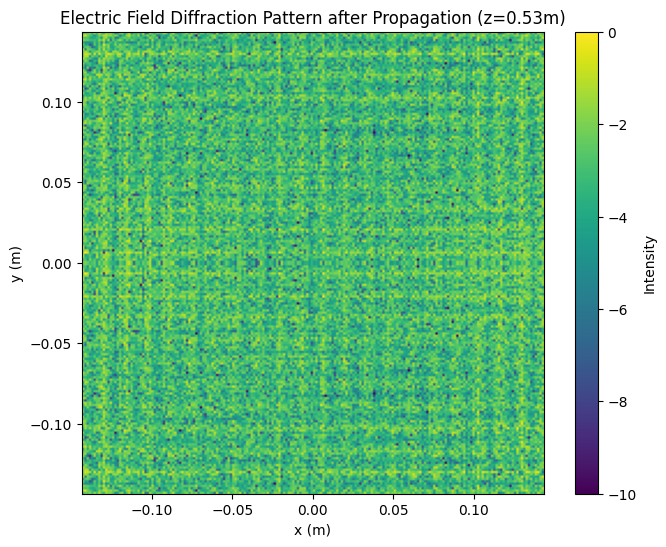

In [33]:
# Propagate through objective lens and evaluate the field 
# at the location of the field lens.

wavelength = 0.0032  # Wavelength in meters (650 nm)
k = 2 * np.pi / wavelength  # Wave number
f = 225e-3  # Focal length of the lens (10 mm)
z = 0.53  # Propagation distance (in meters) after the lens (5 cm)
num_points = 200  # Grid size (must be power of 2 for FFT)
grid_size = 287e-3  # Size of the observation grid in meters (5 mm)
dx = grid_size / num_points  # Grid spacing in meters

# Generate grid for observation points (2D plane)
x_obs = np.linspace(-grid_size / 2, grid_size / 2, num_points)
y_obs = np.linspace(-grid_size / 2, grid_size / 2, num_points)
X_obs, Y_obs = np.meshgrid(x_obs, y_obs)

# Create the binary lens aperture (1 for the lens, 0 for background)
R_lens = 250e-3  # Radius of the lens aperture (1 mm)
X_lens, Y_lens = np.meshgrid(np.linspace(-R_lens, R_lens, num_points),
                             np.linspace(-R_lens, R_lens, num_points))
lens_aperture = (X_lens**2 + Y_lens**2 <= R_lens**2).astype(float)

# Incident plane wave (at the lens plane)
incident_wave = U_obs

# Fourier transform of the aperture (lens effect)
lens_ft = np.fft.fftshift(np.fft.fft2(lens_aperture * incident_wave))

# Compute the spatial frequencies
fx = np.fft.fftshift(np.fft.fftfreq(num_points, dx))
fy = np.fft.fftshift(np.fft.fftfreq(num_points, dx))
FX, FY = np.meshgrid(fx, fy)

# Spatial frequency scaling factor (for propagation)
H = np.exp(1j * k * z) * np.exp(1j * k * (FX**2 + FY**2) * z / (2 * np.pi))

# Propagate the field using the Rayleigh-Sommerfeld 
U_obs = np.fft.ifft2(np.fft.ifftshift(lens_ft * H))

# Normalize the intensity (square of the absolute value)
U_obs_intensity = np.abs(U_obs)**2
U_obs_intensity /= np.max(U_obs_intensity)  # Normalize for visualization

# Plot the diffraction pattern at the observation plane (intensity)
plt.figure(figsize=(8, 6))
plt.imshow(np.log(U_obs_intensity), extent=[x_obs.min(), x_obs.max(), y_obs.min(), y_obs.max()], cmap='viridis', vmin=-10, vmax=0)
plt.colorbar(label='Intensity')
plt.title(f'Electric Field Diffraction Pattern after Propagation (z={z}m)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


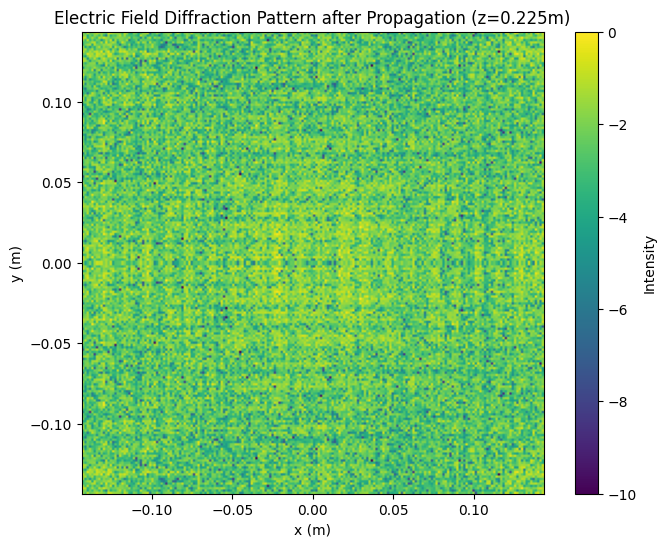

In [34]:
# Propagate through field lens and evaluate the field 
# at FPU

wavelength = 0.0032  # Wavelength in meters (650 nm)
k = 2 * np.pi / wavelength  # Wave number
f = 225e-3  # Focal length of the lens (10 mm)
z = 0.225  # Propagation distance (in meters) after the lens (5 cm)
num_points = 200  # Grid size (must be power of 2 for FFT)
grid_size = 287e-3  # Size of the observation grid in meters (5 mm)
dx = grid_size / num_points  # Grid spacing in meters

# Generate grid for observation points (2D plane)
x_obs = np.linspace(-grid_size / 2, grid_size / 2, num_points)
y_obs = np.linspace(-grid_size / 2, grid_size / 2, num_points)
X_obs, Y_obs = np.meshgrid(x_obs, y_obs)

# Create the binary lens aperture (1 for the lens, 0 for background)
R_lens = 250e-3  # Radius of the lens aperture (1 mm)
X_lens, Y_lens = np.meshgrid(np.linspace(-R_lens, R_lens, num_points),
                             np.linspace(-R_lens, R_lens, num_points))
lens_aperture = (X_lens**2 + Y_lens**2 <= R_lens**2).astype(float)

# Incident plane wave (at the lens plane)
incident_wave = U_obs_intensity

# Fourier transform of the aperture (lens effect)
lens_ft = np.fft.fftshift(np.fft.fft2(lens_aperture * incident_wave))

# Compute the spatial frequencies
fx = np.fft.fftshift(np.fft.fftfreq(num_points, dx))
fy = np.fft.fftshift(np.fft.fftfreq(num_points, dx))
FX, FY = np.meshgrid(fx, fy)

# Spatial frequency scaling factor (for propagation)
H = np.exp(1j * k * z) * np.exp(1j * k * (FX**2 + FY**2) * z / (2 * np.pi))

# Propagate the field using the Rayleigh-Sommerfeld 
U_obs = np.fft.ifft2(np.fft.ifftshift(lens_ft * H))

# Normalize the intensity (square of the absolute value)
U_obs_intensity = np.abs(U_obs)**2
U_obs_intensity /= np.max(U_obs_intensity)  # Normalize for visualization

# Plot the diffraction pattern at the observation plane (intensity)
plt.figure(figsize=(8, 6))
plt.imshow(np.log(U_obs_intensity), extent=[x_obs.min(), x_obs.max(), y_obs.min(), y_obs.max()], cmap='viridis', vmin=-10, vmax=0)
plt.colorbar(label='Intensity')
plt.title(f'Electric Field Diffraction Pattern after Propagation (z={z}m)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()
